<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

### Interactive Workflow of Principal Component Analysis, Eigen Values and Eigen Vectors
      
#### Michael Pyrcz, Associate Professor, University of Texas at Austin,
    
 ##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1) | [GeostatsPy](https://github.com/GeostatsGuy/GeostatsPy),

#### Introduction

This semester I had students asking about how Eigen vectors and values behave in PCA. They wanted to see how they response to structure in covariance matrix. So I made this interactivity to demonstrate and visualize this!

For more check out my YouTube channel [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig). For the walkthrough video of this workflow go here [walkthrough](TBD). Here's some basic concepts on Principal Component Analysis.

#### Principal Component Analysis

Principal Component Analysis one of a variety of methods for dimensional reduction:

Dimensional reduction transforms the data to a lower dimension

* Given features, $𝑋_1,\dots,𝑋_𝑚$  we would require ${m \choose 2}=\frac{𝑚 \cdot (𝑚−1)}{2}$ scatter plots to visualize just the two-dimensional scatter plots.

* Once we have 4 or more variables understanding our data gets very hard.
* Recall the curse of dimensionality, impact inference, modeling and visualization.

One solution, is to find a good lower dimensional, $𝑝$,  representation of the original dimensions $𝑚$

Benefits of Working in a Reduced Dimensional Representation:

1. Data storage / Computational Time
2. Easier visualization
3. Also takes care of multicollinearity

#### Orthogonal Transformation

Convert a set of observations into a set of linearly uncorrelated variables known as principal components

* The number of principal components ($k$) available are min⁡($𝑛−1,𝑚$)

* Limited by the variables/features, $𝑚$, and the number of data

Components are ordered

* First component describes the larges possible variance / accounts for as much variability as possible
* Next component describes the largest possible remaining variance
* Up to the maximum number of principal components

Eigen Values / Eigen Vectors

* The Eigen values are the variance explained for each component
* The Eigen vectors of the data covariance matrix are the principal components' loadings

#### Install Packages

For this interactive workflow to work, we need to install several packages relating to display features, widgets and data analysis interpretation.

#### Make the Dashbaord

The numerical methods for this dashboard are:

1. make a covariance matrix
2. sample jointly from the multiGaussian distribution based on this covariance matrix
3. standardize the samples to correct the mean and variance to 0.0 and 1.0 repsectively
4. calculate the actual covariance matrix / this ensures that the covariance matrix is positive semidefiniate (because it is based on actual data)
5. calculate the Eigen values and vectors, and sort by descending Eigen values
6. plot the original feature variances, Eigen vectors and values.

#### Comments

This was an interactive demonstrations of the Eigen values (variance explained) and Eigen vectors (component loadings) for Principal Components Analysis (PCA) with varianble between feature correlation.

Here we add data correlation / redundancy and observe the impact on the component loadings (Eigen vectors) and variance explained (Eigen values).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import StandardScaler
from numpy.linalg import eig
import matplotlib.cm as cm
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
def generate_data(rho_strength, nos_predictors=4, size=1000, seed=78722, save_csv=False):
    np.random.seed(seed)
    m = nos_predictors
    mean = np.zeros(m)
    cov = np.full((m, m), 0.0)

    # Define the covariance matrix based on rho_strength
    cov[0, 1] = cov[1, 0] = 0.99 * rho_strength
    cov[1, 2] = cov[2, 1] = -0.9 * rho_strength
    cov[0, 2] = cov[2, 0] = -0.7 * rho_strength
    for i in range(m):
        cov[i, i] = 1.0

    data = np.random.multivariate_normal(mean=mean, cov=cov, size=size)
    data = StandardScaler().fit_transform(data)

    if save_csv:
        filename=f'High_Dim_Dataset_rho_{rho_strength}.csv'
        pd.DataFrame(data, columns=[f'Feature_{i+1}' for i in range(m)]).to_csv(filename, index=False)
    return data


def plot_pca_summary(data, title_suffix):
    m = data.shape[1]
    cov_actual = np.cov(data, rowvar=False)
    eigen_values, eigen_vectors = eig(cov_actual)
    sorted_indices = np.argsort(-eigen_values)
    sorted_eigen_vectors = eigen_vectors[:, sorted_indices]
    sorted_eigen_values = np.sort(-eigen_values) * -1

    fig = plt.figure(figsize=(12, 12))
    gs = GridSpec(2, 2, width_ratios=(1, 1))

    # Plot for Eigen Vectors / Principal Component Loadings
    plt_center = fig.add_subplot(gs[1, 1])
    plot_eigen_vectors(plt_center, sorted_eigen_vectors, m)

    # Plot for Original Feature Variance
    plt_x = fig.add_subplot(gs[1, 0], sharey=plt_center)
    plt_x.grid(axis='x',which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    plt_x.grid(axis='x',which='major', color='#DDDDDD', linewidth=0.8); plt_x.minorticks_on()
    plot_original_variance(plt_x, data, m)

    # Plot for Sorted, Projected Feature Variance
    plt_y = fig.add_subplot(gs[0, 1], sharex=plt_center)
    plt_y.grid(axis='y',which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    plt_y.grid(axis='y',which='major', color='#DDDDDD', linewidth=0.8); plt_y.minorticks_on()
    plot_projected_variance(plt_y, sorted_eigen_values, m)

    # Plot for Covariance Matrix
    plt_extra = fig.add_subplot(gs[0, 0])
    plot_covariance_matrix(plt_extra, cov_actual, m)

    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.suptitle(f"PCA Summary: {title_suffix}")
    plt.tight_layout()
    fig.savefig(f"PCA Summary {title_suffix}.png", dpi=300, bbox_inches='tight')
    plt.show()

def plot_eigen_vectors(ax, eigen_vectors, m):
    for i in range(m):
        for j in range(m):
            color = (eigen_vectors[j, i] + 1.0) / 2.0
            ax.add_patch(mpatches.Rectangle((i-0.5, j-0.5), 1, 1, color=plt.cm.RdGy_r(color), fill=True))
            ax.annotate(np.round(eigen_vectors[j, i], 1), (i-0.1, j-0.05), color='white' if abs(eigen_vectors[j, i]) > 0.5 else 'black')
    ax.set_xlim([-0.5, m-0.5]); ax.set_ylim([-0.5, m-0.5])
    ax.set_xticks(range(m)); ax.set_yticks(range(m))
    ax.set_xticklabels(range(1, m+1)); ax.set_yticklabels(range(1, m+1))
    ax.set_title('Eigen Vectors / Principal Component Loadings')
    ax.set_xlabel('Eigen Vector'); ax.set_ylabel('Feature')
    for x in np.arange(0.5, m-0.5, 1.0):
        ax.plot([x, x], [-0.5, m-0.5], c='black', lw=3)
        ax.plot([-0.5, m-0.5], [x, x], c='black', lw=1, ls='--')

def plot_original_variance(ax, data, m):
    ax.barh(y=range(m), width=np.var(data, axis=0), color='darkorange', edgecolor='black')
    ax.set_xlim([3.0, 0])
    ax.set_yticks(range(m))
    ax.set_yticklabels(range(1, m+1))
    ax.set_ylabel('Feature'); ax.set_xlabel('Variance')
    ax.set_title('Original Feature Variance')
    ax.plot([1, 1], [-0.5, m-0.5], c='black', ls='--')
    ax.annotate('Equal Variance', (1.15, m-1.4), rotation=90, size=9)
    for x in np.arange(0.5, m-0.5, 1.0):
        ax.plot([-0.5, m-0.5], [x, x], c='black', lw=1, ls='--')



def plot_projected_variance(ax, eigen_values, m):
    ax.bar(x=range(m), height=eigen_values, color='darkorange', edgecolor='black')
    ax.set_ylim([0, 3.0]); ax.set_xticks(range(m))
    ax.set_xticklabels(range(1, m+1))
    ax.set_xlabel('Eigen Value'); ax.set_ylabel('Variance')
    ax.set_title('Sorted, Projected Feature Variance')
    ax.plot([-0.5, m-0.5], [1, 1], c='black', ls='--')
    ax.annotate('Equal Variance', (m-1.45, 1.05), size=9)
    for x in np.arange(0.5, m-0.5, 1.0):
        ax.plot([x, x], [-0.5, m-0.5], c='black', lw=3)


def plot_covariance_matrix(ax, cov_matrix, m):
    cmap = cm.BrBG  # Choose colormap
    norm = colors.Normalize(vmin=-1.0, vmax=1.0)  # Normalize to the range of covariance values

    for i in range(m):
        for j in range(m):
            color = cmap(norm(cov_matrix[j, i]))
            ax.add_patch(mpatches.Rectangle((i-0.5, j-0.5), 1, 1, color=color, fill=True))
            ax.annotate(np.round(cov_matrix[j, i], 1), (i-0.1, j-0.05), color='white' if abs(cov_matrix[j, i]) > 0.5 else 'black')

    ax.set_xlim([-0.5, m-0.5])
    ax.set_ylim([m-0.5, -0.5])
    ax.set_xticks(range(m))
    ax.set_yticks(range(m))
    ax.set_xticklabels(range(1, m+1))
    ax.set_yticklabels(range(1, m+1))
    ax.set_xlabel('Feature')
    ax.set_ylabel('Feature')
    ax.set_title('Covariance Matrix')#, pad=60)
    for x in np.arange(0.5, m-0.5, 1.0):
        ax.plot([x, x], [-0.5, m-0.5], c='black', lw=2)
        ax.plot([-0.5, m-0.5], [x, x], c='black', lw=2)

    # Create a colorbar
    scalar_mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom', size='5%', pad=0.6)
    plt.colorbar(scalar_mappable, cax=cax, orientation='horizontal', label='Covariance')
    plt.tight_layout()
    plt.show()

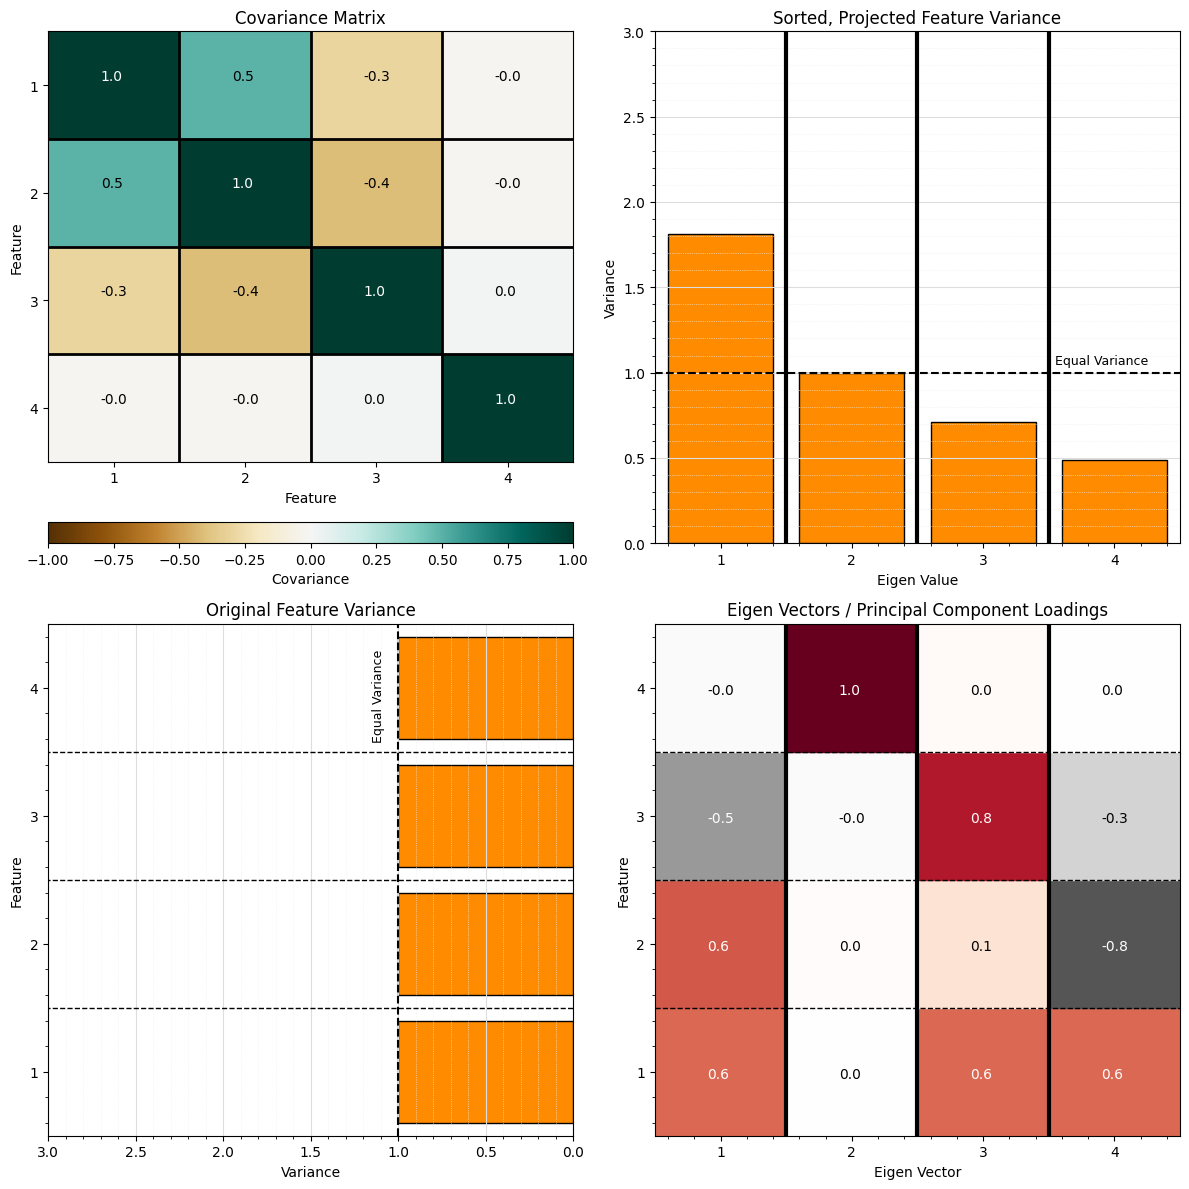

<Figure size 640x480 with 0 Axes>

In [5]:
# Make dataset for a specific rho_strength value and visualize the associated PCA summary
rho_strength = 0.5 #imposed correlation between features, perform for [0, 0.5, 1]
data = generate_data(rho_strength, save_csv=True)
plot_pca_summary(data, f"Rho Strength {rho_strength}")

In [6]:
def generate_data(rho_strength, nos_predictors=4, size=1000, seed=78722, save_csv=False):
    np.random.seed(seed)
    m = nos_predictors
    mean = np.zeros(m)
    cov = np.full((m, m), 0.0)

    # Define the covariance matrix based on rho_strength
    cov[0, 1] = cov[1, 0] = 0.99 * rho_strength
    cov[1, 2] = cov[2, 1] = -0.9 * rho_strength
    cov[0, 2] = cov[2, 0] = -0.7 * rho_strength
    for i in range(m):
        cov[i, i] = 1.0

    data = np.random.multivariate_normal(mean=mean, cov=cov, size=size)
    data = StandardScaler().fit_transform(data)

    # Create the target variable based on the conditions described
    medians = np.median(data, axis=0)
    target = np.full(size, 4)  # Default category

    # Applying conditions for categorization
    for i in range(size):
        if data[i, 0] > medians[0] and data[i, 1] > medians[1]:
            target[i] = 1
        elif data[i, 2] > medians[2] and data[i, 3] < medians[3]:
            target[i] = 2
        elif data[i, 0] < medians[0] and data[i, 2] > medians[2]:
            target[i] = 3

    if save_csv:
        df = pd.DataFrame(data, columns=[f'Feature_{i+1}' for i in range(m)])
        df['Target'] = target
        filename=f'High_Dim_Dataset_with_Target_rho_{rho_strength}.csv'
        df.to_csv(filename, index=False)

    return data, target

def plot_pca_summary(data, title_suffix):
    m = data.shape[1]
    cov_actual = np.cov(data, rowvar=False)
    eigen_values, eigen_vectors = eig(cov_actual)
    sorted_indices = np.argsort(-eigen_values)
    sorted_eigen_vectors = eigen_vectors[:, sorted_indices]
    sorted_eigen_values = np.sort(-eigen_values) * -1

    fig = plt.figure(figsize=(12, 12))
    gs = GridSpec(2, 2, width_ratios=(1, 1))

    # Plot for Eigen Vectors / Principal Component Loadings
    plt_center = fig.add_subplot(gs[1, 1])
    plot_eigen_vectors(plt_center, sorted_eigen_vectors, m)

    # Plot for Original Feature Variance
    plt_x = fig.add_subplot(gs[1, 0], sharey=plt_center)
    plot_original_variance(plt_x, data, m)
    plt_x.grid(axis='x',which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    plt_x.grid(axis='x',which='major', color='#DDDDDD', linewidth=0.8); plt_x.minorticks_on()

    # Plot for Sorted, Projected Feature Variance
    plt_y = fig.add_subplot(gs[0, 1], sharex=plt_center)
    plot_projected_variance(plt_y, sorted_eigen_values, m)
    plt_y.grid(axis='y',which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    plt_y.grid(axis='y',which='major', color='#DDDDDD', linewidth=0.8); plt_y.minorticks_on()

    # Plot for Covariance Matrix
    plt_extra = fig.add_subplot(gs[0, 0])
    plot_covariance_matrix(plt_extra, cov_actual, m)

    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.suptitle(f"PCA Summary: {title_suffix}")
    plt.tight_layout()
    fig.savefig(f"PCA Summary {title_suffix}.png", dpi=300, bbox_inches='tight')
    plt.show()

def plot_eigen_vectors(ax, eigen_vectors, m):
    for i in range(m):
        for j in range(m):
            color = (eigen_vectors[j, i] + 1.0) / 2.0
            ax.add_patch(mpatches.Rectangle((i-0.5, j-0.5), 1, 1, color=plt.cm.RdGy_r(color), fill=True))
            ax.annotate(np.round(eigen_vectors[j, i], 1), (i-0.1, j-0.05), color='white' if abs(eigen_vectors[j, i]) > 0.5 else 'black')
    ax.set_xlim([-0.5, m-0.5]); ax.set_ylim([-0.5, m-0.5])
    ax.set_xticks(range(m)); ax.set_yticks(range(m))
    ax.set_xticklabels(range(1, m+1)); ax.set_yticklabels(range(1, m+1))
    ax.set_title('Eigen Vectors / Principal Component Loadings')
    ax.set_xlabel('Eigen Vector'); ax.set_ylabel('Feature')
    for x in np.arange(0.5, m-0.5, 1.0):
        ax.plot([x, x], [-0.5, m-0.5], c='black', lw=3)
        ax.plot([-0.5, m-0.5], [x, x], c='black', lw=1, ls='--')

def plot_original_variance(ax, data, m):
    ax.barh(y=range(m), width=np.var(data, axis=0), color='darkorange', edgecolor='black')
    ax.set_xlim([3.0, 0])
    ax.set_yticks(range(m))
    ax.set_yticklabels(range(1, m+1))
    ax.set_ylabel('Feature'); ax.set_xlabel('Variance')
    ax.set_title('Original Feature Variance')
    ax.plot([1, 1], [-0.5, m-0.5], c='black', ls='--')
    ax.annotate('Equal Variance', (1.15, m-1.4), rotation=90, size=9)
    for x in np.arange(0.5, m-0.5, 1.0):
        ax.plot([-0.5, m-0.5], [x, x], c='black', lw=1, ls='--')



def plot_projected_variance(ax, eigen_values, m):
    ax.bar(x=range(m), height=eigen_values, color='darkorange', edgecolor='black')
    ax.set_ylim([0, 3.0]); ax.set_xticks(range(m))
    ax.set_xticklabels(range(1, m+1))
    ax.set_xlabel('Eigen Value'); ax.set_ylabel('Variance')
    ax.set_title('Sorted, Projected Feature Variance')
    ax.plot([-0.5, m-0.5], [1, 1], c='black', ls='--')
    ax.annotate('Equal Variance', (m-1.45, 1.05), size=9)
    for x in np.arange(0.5, m-0.5, 1.0):
        ax.plot([x, x], [-0.5, m-0.5], c='black', lw=3)


def plot_covariance_matrix(ax, cov_matrix, m):
    cmap = cm.BrBG  # Choose colormap
    norm = colors.Normalize(vmin=-1.0, vmax=1.0)  # Normalize to the range of covariance values

    for i in range(m):
        for j in range(m):
            color = cmap(norm(cov_matrix[j, i]))
            ax.add_patch(mpatches.Rectangle((i-0.5, j-0.5), 1, 1, color=color, fill=True))
            ax.annotate(np.round(cov_matrix[j, i], 1), (i-0.1, j-0.05), color='white' if abs(cov_matrix[j, i]) > 0.5 else 'black')

    ax.set_xlim([-0.5, m-0.5])
    ax.set_ylim([m-0.5, -0.5])
    ax.set_xticks(range(m))
    ax.set_yticks(range(m))
    ax.set_xticklabels(range(1, m+1))
    ax.set_yticklabels(range(1, m+1))
    ax.set_xlabel('Feature')
    ax.set_ylabel('Feature')
    ax.set_title('Covariance Matrix')#, pad=60)
    for x in np.arange(0.5, m-0.5, 1.0):
        ax.plot([x, x], [-0.5, m-0.5], c='black', lw=2)
        ax.plot([-0.5, m-0.5], [x, x], c='black', lw=2)

    # Create a colorbar
    scalar_mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom', size='5%', pad=0.6)
    plt.colorbar(scalar_mappable, cax=cax, orientation='horizontal', label='Covariance')
    plt.tight_layout()
    plt.show()

/var/folders/31/m0j7418x4hj7b2sdjjsz_8q00000gn/T/ipykernel_85488/1899204436.py:14: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  data = np.random.multivariate_normal(mean=mean, cov=cov, size=size)


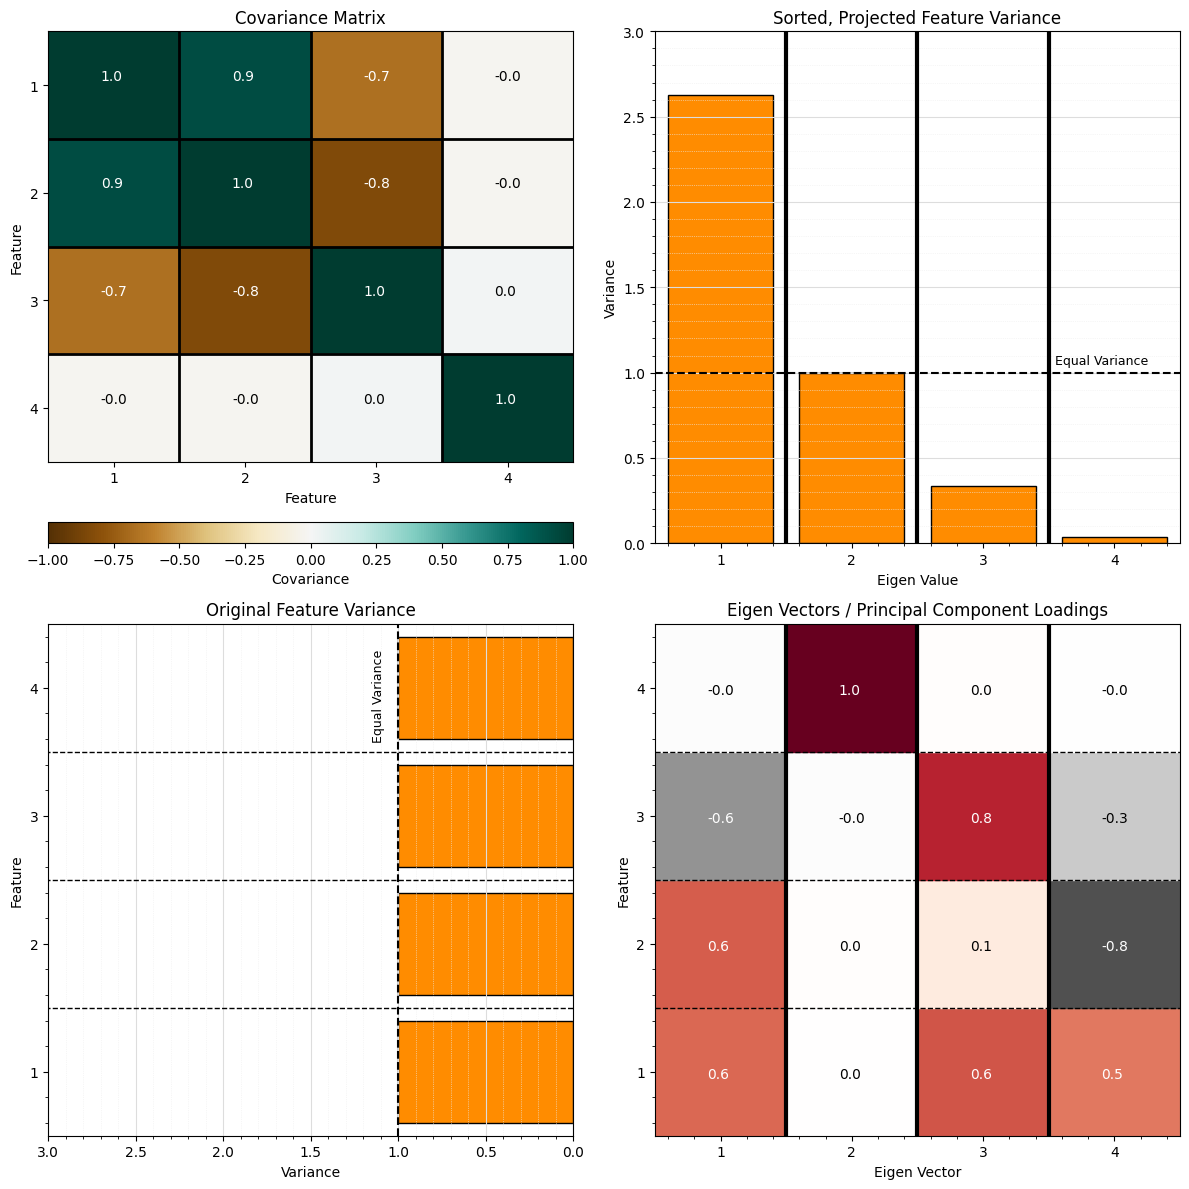

<Figure size 640x480 with 0 Axes>

In [10]:
# Make dataset for a specific rho_strength value and visualize the associated PCA summary
rho_strength = 1
data, target = generate_data(rho_strength, save_csv=True)
# data.shape, target.shape
plot_pca_summary(data, f"Rho Strength {rho_strength}")